In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import theano.tensor as tt


SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep', 'arviz-colors', 'arviz-white', 'arviz-whitegrid', 'arviz-darkgrid']


In [2]:
class Ornstein_Uhlenbeck(pm.Continuous):
    """
    Ornstein-Uhlenbeck Process
    Parameters
    ----------
    B : tensor
        B > 0, B = exp(-(D/A)*delta_t)
    A : tensor
        A > 0, amplitude of fluctuation <x**2>=A
    delta_t: scalar
        delta_t > 0, time step
    """

    def __init__(self, A=None, B=None,
                 *args, **kwargs):
        super(Ornstein_Uhlenbeck, self).__init__(*args, **kwargs)
        self.A = A
        self.B = B
        self.mean = 0.

    def logp(self, x):
        A = self.A
        B = self.B

        x_im1 = x[:-1]
        x_i = x[1:]

        ou_like = pm.Normal.dist(mu=x_im1*B, tau=1.0/A/(1-B**2)).logp(x_i)
        return pm.Normal.dist(mu=0.0,tau=1.0/A).logp(x[0]) + tt.sum(ou_like)


In [7]:
data = np.load("OUmt_sN05.npy")
data = data[:2]

In [6]:
a_bound = 10
result_df = pd.DataFrame(columns=['A', 'dA','B','dB','s','ds'])
for dataset in data:
    delta_t = dataset[0]
    ts = dataset[1:]
    print(delta_t)
    with pm.Model() as model:
        B = pm.Beta('B', alpha=1.0,beta=1.0)
        A = pm.Uniform('A', lower=0, upper=a_bound)
        sigma = pm.Uniform('sigma',lower=0,upper=5)

        path = Ornstein_Uhlenbeck('path',A=A, B=B,shape=len(ts))
        dataObs = pm.Normal('dataObs',mu=path,sigma=sigma,observed=ts)
        trace = pm.sample(2000,cores=4)
        
    a_mean = trace['A'].mean()
    b_mean = trace['B'].mean()
    a_std = trace['A'].std()
    b_std = trace['B'].std()
    sigma_mean = trace['sigma'].mean()
    sigma_std = trace['sigma'].std()
    
    result_df.append({'A':a_mean,
                      'dA':a_std,
                      'B':b_mean,
                      'dB':b_std,
                      's':sigma_mean,
                      'ds':sigma_std})
    

0.01


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences:  12%|█▏        | 1199/10000 [08:52<1:05:07,  2.25draws/s]


ValueError: Not enough samples to build a trace.

In [86]:
tau = -delta_t_list/np.log(result_array.T[2])
dtau = delta_t_list*result_array.T[3]/result_array.T[2]/np.log(result_array.T[2])**2

Text(0, 0.5, '$\\sigma_{GT-model}$')

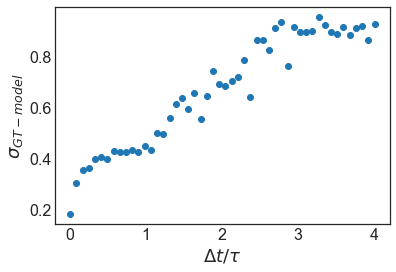

In [95]:
plt.plot(delta_t_list,result_array.T[6],"o")
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel(r'$\sigma_{GT-model}$')

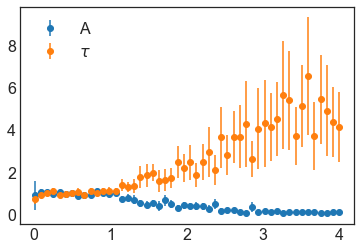

In [99]:
plt.errorbar(delta_t_list,result_array.T[0],yerr=result_array.T[1],fmt="o",label="A")
plt.errorbar(delta_t_list,tau,dtau,fmt="o",label=r'$\tau$')
plt.legend(loc="upper left")

Text(0, 0.5, '$\\sigma_{noise}$')

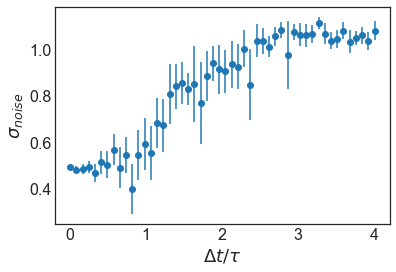

In [101]:
plt.errorbar(delta_t_list,result_array.T[4],yerr=result_array.T[5],fmt="o")
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel(r'$\sigma_{noise}$')